In [1]:
import pandas as pd
import json
import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
from collections import deque
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import sys 
sys.path.append('../')
from fast_tsne.fast_tsne import fast_tsne

In [4]:
from eval_canarex import calculate_mse

## Cluster results

In [5]:
path='canarex_coref_text'
ctype='coref_text'

cpath = '{}/kmeans_all.pkl'.format(path)
narratives_path='{}/final_narratives.jsonl'.format(path)
result_path = '{}/results.jsonl'.format(path)
eval_path = '{}/eval_output.csv'.format(path)


### Load scores

In [6]:
df = pd.read_pickle(cpath)

In [7]:
df.head(2)

,k,score,dist,labels
0,2,0.110007,"[1.0786139, 1.0129762, 0.93938935, 0.41308832,...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
0,3,0.131193,"[1.0521417, 0.9711358, 1.0121782, 0.40926528, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
df = df[df.score == df.score.max()]
df = df.explode(['dist', 'labels'])
df = df.reset_index(drop = True)

In [9]:
df.shape

(421247, 4)

In [10]:
df.labels.nunique()

4

### Merge narratives

In [11]:
narratives_path

'canarex_coref_text/final_narratives.jsonl'

In [12]:
chunks = pd.read_json(narratives_path, 
                      lines=True, chunksize=10000)
narratives = None
for chunk in chunks:
    if narratives is None:
        narratives = chunk
    else:
        narratives = pd.concat([narratives, chunk], axis=0)

In [13]:
final = pd.concat([narratives, df.reset_index(drop = True)],
                  axis = 1)

In [14]:
final.shape

(421247, 19)

In [16]:
final[final.noise == False].groupby(['synthetic_label', 'labels']).\
size().\
reset_index(name='l').\
sort_values(['synthetic_label', 'l'], ascending=[True, False]).\
groupby(['synthetic_label']).\
head(3)

,synthetic_label,labels,l
3,1,3,56737
1,1,1,4602
2,1,2,456
4,2,0,75933
5,2,1,13573
7,2,3,1248
10,3,2,142879
9,3,1,20827
11,3,3,775


### Save output

In [15]:
result_path

'canarex_coref_text/results.jsonl'

In [34]:
final.to_json(result_path, lines = True, orient='records')

### Original cluster

In [16]:
df = pd.read_json('{}/synthetic_test_data_{}.jsonl'.format('synthetic_data', ctype), 
                  lines = True, orient='records')

In [17]:
df.drop(columns='text').head(2)

,id,sent_id,time,synthetic_label,sentence_id,noise
0,3a720591-c06f-4382-8a6c-8d26c7a356bf,0,0,1,3a720591-c06f-4382-8a6c-8d26c7a356bf_0,True
1,3a720591-c06f-4382-8a6c-8d26c7a356bf,1,0,1,3a720591-c06f-4382-8a6c-8d26c7a356bf_1,True


In [18]:
df.synthetic_label.value_counts()

3    154870
2    111124
1     74807
Name: synthetic_label, dtype: int64

In [24]:
# 1 = triangle (kevin rudd)
# 2 = square (climate change)
# 3 = random wave (Indeginous people)

### Calculate MSE

In [25]:
df = pd.read_json('{}/synthetic_test_data_{}.jsonl'.format('synthetic_data', ctype), 
                  lines = True, orient='records')

In [26]:
result_path

'canarex_coref_text/results.jsonl'

In [27]:
final = pd.read_json(result_path, lines = True)

In [28]:
final.drop(columns='text').head(2)

,id,verb,entity1,entity2,combined,ARGM-LOC,ARGM-TMP,narrative,sentence_id,sent,sent_id,time,synthetic_label,noise,k,score,dist,labels
0,0002060a-61bb-40f6-a843-40d1acbaf858,stole,A person,over $ 1000,"[A person, over $ 1000, for]",,,[A person] (stole) [over $ 1000],0002060a-61bb-40f6-a843-40d1acbaf858_0,A person stole over $ 1000,0,295,2,True,4,0.144362,1.002397,1
1,0002060a-61bb-40f6-a843-40d1acbaf858,delivered,the Red Cross,parcels,"[the Red Cross, parcels, to Adelaide]",at various locations,,[the Red Cross] (delivered) [parcels],0002060a-61bb-40f6-a843-40d1acbaf858_1,the Red Cross delivered parcels,1,295,2,True,4,0.144362,0.925335,1


In [29]:
eval_df = calculate_mse(df, final)

In [30]:
eval_df[eval_df.mse == eval_df.groupby(['orig_clust'])['mse'].transform('min')]

,orig_clust,pred_clust,intercept,coef,mse,r_sq
3,1,3,-3.81289,1.274363,46.770132,0.998164
6,2,0,-3.792096,1.375623,79.376873,0.998461
9,3,2,-4.492334,1.343579,155.413557,0.985731


In [31]:
eval_path

'canarex_coref_text/eval_output.csv'

In [31]:
eval_df.to_csv(eval_path, index = False)

### Create label mapping

In [32]:
label_mapping = eval_df[eval_df.mse == eval_df.groupby(['orig_clust'])['mse'].transform('min')]
label_mapping = label_mapping[['orig_clust', 'pred_clust']]
label_mapping = label_mapping.rename(columns = {'pred_clust': 'labels',
                                      'orig_clust':'new_labels'})

In [33]:
label_mapping

,new_labels,labels
3,1,3
6,2,0
9,3,2


In [34]:
# column, new_labels: mapped original cluster assignments (3 clusters)
# column, labels: new cluster assignments (N clusters)

# Map the rest of the (N-3) labels to a single cluster (as it is not considered recovery)
# Used for plotting graphs
pending_labels = deque()
pending_labels.extend(set(range(0, final.labels.nunique())) - set(label_mapping.labels.tolist()))

label_mapping_dict = []
for i in range(4, 4 + len(pending_labels)):
    label_mapping_dict.append({'new_labels': 4, 'labels':pending_labels.pop()})

# Add pending labels
label_mapping = pd.concat([label_mapping, pd.DataFrame(label_mapping_dict)], axis = 0).reset_index(drop = True)

In [35]:
# narrative cluster assignments mapped to orignial synthetic cluster
# Cluster 1 = triangle (kevin rudd)
# Cluster 2 = square (climate change)
# Cluster 3 = random wave (Indeginous people)
# Cluster 4 = Other new cluster identified (we treat this as noise)
label_mapping

,new_labels,labels
0,1,3
1,2,0
2,3,2
3,4,1


In [36]:
final = pd.merge(final, label_mapping)

### Plot narrative clusters

In [37]:
cluster_labels = {1:'Cluster 1: Kevin Rudd', #18, #synthetic label 1, Kevin Rudd
2:'Cluster 2: Climate change', # 24 #synthetic label 2 Climate change
3:'Cluster 3: Indeginous people', #63 #synthetic label 3, Indeginous people
4: 'Cluster 4: New cluster'}

colour = {'1':'#abd9e9',
'2':'#fdae61',
'3': '#D2AB3C',
'4': '#5ab4ac'}

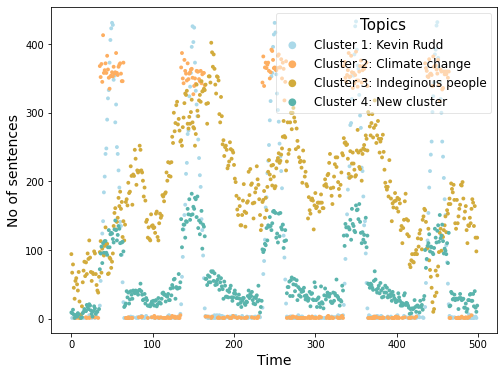

In [38]:
test = final[final.noise == False]\
[['sentence_id','time', 'text', 'synthetic_label', 'noise', 'new_labels']].drop_duplicates()
test = test.groupby(['time', 'new_labels']).size().reset_index(name='l')
test = test.sort_values(by=['new_labels'], key=lambda x: x.map(cluster_labels))

fig, ax = plt.subplots(figsize=(8,6))
for label in test.new_labels.unique():
    ax.scatter(test[test.new_labels == label].time.tolist(), 
               test[test.new_labels == label].l.tolist(), 
               c=[colour[str(i)] for i in test[test.new_labels == label].new_labels.tolist()], 
               s=15, label=cluster_labels[label],
               alpha=1, edgecolors='none')

ax.legend(title='Topics', loc=1, prop={'size': 12}, 
          title_fontsize=15, markerscale=2, framealpha=0.5)
ax.grid(False)
ax.set_ylabel("No of sentences", size=14)
ax.set_xlabel("Time", size=14)
ax.grid(False)
plt.show()
fig.savefig('pics/test_clusters_timeseries_results_all_coref_text_without_noise.png', bbox_inches='tight')